> ref: https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.28992

In [1]:
import logging
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DataLoader:
    @staticmethod
    def parse_mrd(mrd):
        if not isinstance(mrd, bytes):
            return None
        if len(mrd) < 512:
            return None

        samples = int(0).from_bytes(mrd[0:4], byteorder='little', signed=True)
        views = int(0).from_bytes(mrd[4:8], byteorder='little', signed=True)
        views2 = int(0).from_bytes(mrd[8:12], byteorder='little', signed=True)
        slices = int(0).from_bytes(mrd[12:16], byteorder='little', signed=True)
        # 16-18 Unspecified
        datatype = int(0).from_bytes(mrd[18:20], byteorder='little', signed=True)
        # 20-152 Unspecified
        echoes = int(0).from_bytes(mrd[152:156], byteorder='little', signed=True)
        experiments = int(0).from_bytes(mrd[156:160], byteorder='little', signed=True)

        nele = experiments * echoes * slices * views * views2 * samples

        if datatype & 0xf == 0:
            dt = 'u1'
            eleSize = 1
        elif datatype & 0xf == 1:
            dt = 'i1'
            eleSize = 1
        elif datatype & 0xf == 2:
            dt = 'i2'
            eleSize = 2
        elif datatype & 0xf == 3:
            dt = 'i2'
            eleSize = 2
        elif datatype & 0xf == 4:
            dt = 'i4'
            eleSize = 4
        elif datatype & 0xf == 5:
            dt = 'f4'
            eleSize = 4
        elif datatype & 0xf == 6:
            dt = 'f8'
            eleSize = 8
        else:
            logging.error('Unknown data type in the MRD file!')
            return None
        if datatype & 0x10:
            eleSize *= 2

        #
        # XXX - The value of NO_AVERAGES in PPR cannot be used to
        #       calculate the data size.
        #       Maybe COMPLETED_AVERAGES? ref. p14 of the manual
        #
        posPPR = mrd.rfind(b'\x00')
        if posPPR == -1:
            logging.error('Corrupted MRD file!')
            return None
        posPPR += 1
        dataSize = posPPR - 512 - 120
        if dataSize < nele * eleSize:
            logging.error('Corrupted MRD file!')
            return None

        ndata = dataSize // (nele * eleSize)
        data = []

        offset = 512
        for i in range(ndata):
            x = np.frombuffer(mrd[offset:],
                              dtype=[('re', '<' + dt), ('im', '<' + dt)] if (datatype & 0x10) else ('<' + dt),
                              count=nele)
            if dt in ('f4', 'f8'):
                pass
            else:
                x = x.astype(np.float32)

            if datatype & 0x10:
                if dt in ('f8',):
                    x = x.view(np.complex128)
                else:
                    x = x.view(np.complex64)

            x = x.reshape((experiments, echoes, slices, views, views2, samples))

            offset += nele * eleSize

            data.append(x)

        if offset != posPPR - 120:
            logging.warning('Corrupted MRD file!')

        output = {}
        output['description'] = mrd[256:512].decode('cp437', errors='ignore').rstrip('\0')
        output['data'] = data
        output['sampleInfoFilePath'] = mrd[(posPPR - 120):posPPR].decode('cp437', errors='ignore').rstrip('\0')
        # output['pulseq'] = SmisPulseq(mrd[posPPR:])

        return output

    @staticmethod
    def reshape_data_to_2d(primary_coil_data, external_coils_data):
        primary_coil_data = np.array(primary_coil_data)
        external_coils_data = np.array(external_coils_data)

        experiments, echoes, slices, views, views2, samples = primary_coil_data.shape # 手册上的views2实际发现是slices
        coil_num = external_coils_data.shape[0]

        primary_coil_data = primary_coil_data.reshape((views, views2, samples))
        external_coils_data = external_coils_data.reshape((coil_num, views, views2, samples))
        return np.swapaxes(primary_coil_data, 0, 1), np.swapaxes(external_coils_data, 1, 2)

    def __init__(self, root, set_id=1):
        if not os.path.exists(root):
            logging.error('The root path does not exist!')
            return
        if not os.path.exists(os.path.join(root, 'set {}'.format(set_id))):
            logging.error('The set path does not exist!')
            return
        self.root = root
        self.set_id = set_id

    def load_train_data(self, exp_id=1):
        path = os.path.join(self.root, 'set {}'.format(self.set_id), 'noise data', 'exp{}'.format(exp_id))
        if not os.path.exists(path):
            logging.error('The experiment path does not exist!')
            return None

        with open(os.path.join(path, 'noise1.mrd'), 'rb') as f:
            primary_coil_data = self.parse_mrd(f.read())['data'][0]

        external_coils_data = []
        i = 2
        while True:
            data_path = os.path.join(path, 'noise{}.mrd'.format(i))
            if not os.path.exists(data_path):
                break
            with open(data_path, 'rb') as f:
                external_coils_data.append(self.parse_mrd(f.read())['data'][0])
            i += 1

        return self.reshape_data_to_2d(primary_coil_data, external_coils_data)

    def load_test_data(self, exp_id=1):
        path = os.path.join(self.root, 'set {}'.format(self.set_id), 'scan data', 'exp{}'.format(exp_id))
        if not os.path.exists(path):
            logging.error('The experiment path does not exist!')
            return None

        with open(os.path.join(path, 'scan1.mrd'), 'rb') as f:
            primary_coil_data = self.parse_mrd(f.read())['data'][0]

        external_coils_data = []
        i = 2
        while True:
            data_path = os.path.join(path, 'scan{}.mrd'.format(i))
            if not os.path.exists(data_path):
                break
            with open(data_path, 'rb') as f:
                external_coils_data.append(self.parse_mrd(f.read())['data'][0])
            i += 1

        primary_coil_data = np.array(primary_coil_data)
        external_coils_data = np.array(external_coils_data)

        return self.reshape_data_to_2d(primary_coil_data, external_coils_data)

    def set_set_id(self, set_id):
        self.set_id = set_id


In [3]:
def reconImagesByFFT(kdata, size):
    if isinstance(size, int):
        size = (size, size)

    try:
        # experiments, echoes, slices, views, views2, samples = kdata.shape
        idata = np.fft.fftshift(np.fft.ifftn(kdata, s=(size[0], kdata.shape[4], size[1]),
                                             axes=(3, 4, 5)),
                                axes=(3, 4, 5))
    except Exception as e:
        return []

    idata = np.abs(idata)
    idata /= idata.max()

    images = []
    for e in range(idata.shape[0]):
        for k in range(idata.shape[1]):
            for s in range(idata.shape[2]):
                for v2 in range(idata.shape[4]):
                    images.append(idata[e, k, s, :, v2, :])
                    
    return images

In [4]:
class EDITER:
    @staticmethod
    def calculate_h(E, e):
        h = np.linalg.pinv(E) @ e.flatten()
        return h

    @staticmethod
    def cluster(H, threshold=0.5):
        # normalize
        H = H / np.linalg.norm(H, axis=0)

        H_conj_T = H.conj().T
        C = np.dot(H_conj_T, H)
        C_threshold = (C >= threshold).astype(int)

        groups_range = []
        r = 0
        W = H.shape[1]
        while r < W:
            l = r
            while r < W and C_threshold[l, r] == 1:
                r += 1
            groups_range.append([l, r])
        return groups_range

    def __init__(self, W, window_size=(3, 1)):
        self.W = W
        self.window_size = window_size
        self.model = None

    # 生成EMI_conv_matrix
    def EMI_conv_matrix(self, detectors):
        delta_kx, delta_ky = self.window_size
        lines = []
        kx, ky = detectors[0].shape
        if kx < delta_kx or ky < delta_ky:
            print(f"detectors的大小必须大于等于window_size! kx: {kx}, ky: {ky}, delta_kx: {delta_kx}, delta_ky: {delta_ky}")
            return

        for i_x in range(kx - delta_kx + 1):
            for i_y in range(ky - delta_ky + 1):
                line = np.concatenate(tuple(
                    d[i_x:i_x + delta_kx, i_y:i_y + delta_ky].flatten() for d in detectors
                ))
                lines.append(line)
        E = np.vstack(tuple(lines))
        return E

    def divide_data_into_groups(self, detectors, e):
        width = detectors.shape[1]
        if width % self.W != 0:
            print(f"kx 必须是 W 的整数倍！ kx: {width}, W: {self.W}")
            return

        sub_width = width // self.W
        return [[detectors[:, :, k*sub_width:(k+1)*sub_width], e[:, k*sub_width:(k+1)*sub_width]] for k in range(self.W)]

    def cut_e(self, e):
        delta_kx, delta_ky = self.window_size
        kx, ky = e.shape
        e = e[(delta_kx-1)//2:kx-(delta_kx-1)//2, (delta_ky-1)//2:ky-(delta_ky-1)//2]
        return e

    def get_H(self, datas):
        H = []
        for detectors_in_group, e_in_group in datas:
            E = self.EMI_conv_matrix(detectors_in_group)
            e = self.cut_e(e_in_group)
            H.append(self.calculate_h(E, e))
        H = np.array(H).reshape(len(datas), -1).T
        return H

    def get_clustered_H(self, H, detectors, e):
        clustered_groups_range = self.cluster(H)
        width = detectors.shape[1] // self.W
        clustered_groups_range = [[l * width, r * width] for l, r in clustered_groups_range]

        clustered_groups = [[detectors[:, :, i:j], e[:, i:j]] for i, j in clustered_groups_range]
        clustered_H = [self.calculate_h(self.EMI_conv_matrix(detectors_in_group), self.cut_e(e_in_group))
                       for detectors_in_group, e_in_group in clustered_groups]
        return np.array(clustered_H).T, clustered_groups_range

    def train(self, detectors, e):
        groups = self.divide_data_into_groups(detectors, e)

        H = self.get_H(groups)

        H, H_range = self.get_clustered_H(H, detectors, e)

        self.model = H, np.array(H_range)

    def group_detectors_by_range(self, detectors, H_range):
        return [detectors[:, :, l:r] for l, r in H_range]

    def group_e_by_range(self, e, range):
        return [e[:, l:r] for l, r in range]

    def cut_e(self, e):
        delta_kx, delta_ky = self.window_size
        kx, ky = e.shape
        e = e[(delta_kx-1)//2:kx-(delta_kx-1)//2, (delta_ky-1)//2:ky-(delta_ky-1)//2]
        return e


    def cancel_noise(self, s_e, detectors):
        if self.model is None:
            print("You must train the model first!")
            return
        H, H_range = self.model
        # group s_e by H_range
        detectors_groups = self.group_detectors_by_range(detectors, H_range)
        s_e_groups = self.group_e_by_range(s_e, H_range)
        out = []
        for i in range(len(H_range)):
            detectors_in_group = detectors_groups[i]
            E = self.EMI_conv_matrix(detectors_in_group)
            kx, ky = s_e_groups[i].shape
            pred_e = np.zeros((kx, ky), dtype=np.complex64)
            flatten_pred_e = np.dot(E, H[:, i])
            pred_e[self.window_size[0]//2:kx-self.window_size[0]//2, self.window_size[1]//2:ky-self.window_size[1]//2] = flatten_pred_e.reshape(kx-self.window_size[0]+1, ky-self.window_size[1]+1)
            out.append(s_e_groups[i] - pred_e)
        return np.hstack(out)

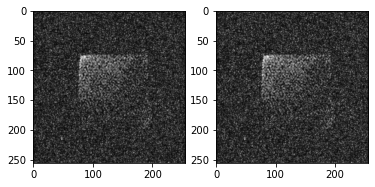

Done!


In [5]:
data_loader = DataLoader("datasets/HYC")
primary_coil_data, extermal_coils_data = data_loader.load_train_data()

editer = EDITER(W=16, window_size=(3, 1))
editer.train(extermal_coils_data[0], primary_coil_data[0])

primary_coil_data, extermal_coils_data = data_loader.load_test_data()
s_and_e = primary_coil_data[0]
s = editer.cancel_noise(primary_coil_data[0], extermal_coils_data[0])

x, y = s_and_e.shape
noise_img = reconImagesByFFT(s_and_e.reshape(1, 1, 1, x, 1, y), 256)
noise_img = noise_img[0]

no_noise_img = editer.cancel_noise(s_and_e, extermal_coils_data[0])
no_noise_img = reconImagesByFFT(no_noise_img.reshape(1, 1, 1, x, 1, y), 256)[0]
plt.subplot(1, 2, 1)
plt.imshow(noise_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(no_noise_img, cmap='gray')
plt.show()

print("Done!")